# CNN: Classification of CHD cases
## Model training

In [1]:
# Install required packages
# %pip install -q numpy pandas matplotlib tensorflow imblearn torch 
# %reset -f

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from IPython.display import display, Markdown



In [3]:
# Define helper functions

def to_list(df_dict, heads):
    """Convert dataframe to dictionaries"""
    # {key: [], ...}
    out = {}
    for _key in list(heads):
        out[_key] = [df_dict[_key][key] for key in df_dict[_key].keys()]
    return out

def encode_input(data_range, data):
    """Encode categorical variables with string categories into numerical categoriess"""
    return data_range.index(data)

def preprocess_data(df_list: dict, normalize=True) -> np.ndarray:
    """Preprocess data into np.arrays (encode if needed)"""
    output = []
    data_length = len(df_list['chd'])
    for i in range(data_length):
        item = []
        for key in list(df_list.keys())[1:]:
            item.append(df_list[key][i])
        output.append(item)
    inputs_arr = np.array(output)
    targets_arr = np.array(df_list['chd'])
    if normalize:
        _range = np.max(inputs_arr, axis=0) - np.min(inputs_arr, axis=0)
        inputs_arr = (inputs_arr-np.min(inputs_arr, axis=0)) / _range
    return inputs_arr, targets_arr

def prepare_data(inputs, targets, seed=1001):
    """Prepare data for CNN"""
    positive_mask = targets == 1
    negative_mask = targets == 0
    
    #Choose between a. and b. 
        # a. Use the next 6 lines of code if need to balance sample by undersampling
    np.random.seed(seed)
    n_minimum = min(np.sum(positive_mask), np.sum(negative_mask))

    positive_indices = random.sample(range(np.sum(positive_mask)), n_minimum)
    negative_indices = random.sample(range(np.sum(negative_mask)), n_minimum)

    positive_inputs = inputs[positive_mask][positive_indices, ]
    positive_targets = targets[positive_mask][positive_indices, ]
    negative_inputs = inputs[negative_mask][negative_indices,]
    negative_targets = targets[negative_mask][negative_indices,]
    inputs = np.concatenate([positive_inputs, negative_inputs]).tolist()
    targets = np.concatenate([positive_targets, negative_targets]).tolist()

        # b. Use next two lines if no need to balance samples 
    #inputs = inputs.tolist()
    #targets = targets.tolist()

    np.random.seed(seed)
    np.random.shuffle(inputs)
    np.random.seed(seed)
    np.random.shuffle(targets)
    return np.array(inputs), np.array(targets)

def get_metrics(y_pred, y_true):
    """Calculate metrics from confusion matrix"""
    _confusion_matrix = confusion_matrix(y_pred, y_true)
    tp = _confusion_matrix[0,0]
    fn = _confusion_matrix[1,0]
    fp = _confusion_matrix[0,1]
    tn = _confusion_matrix[1,1]
    # metrics
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fscore = 2*tp/(2*tp + fp + fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    miss_rate = fn/(tn+tp)
    fall_out_rate = fp/(fp+tn)
    # return [precision, recall, fscore, accuracy, miss_rate, fall_out_rate]
    return [precision, recall, fscore, accuracy, miss_rate, fall_out_rate]

def present_metrics(results_dict): 
    """Generate data frame of metrics"""
    df = pd.DataFrame(results_dict, index = ['Precision', 'Recall', 'F-score', 'Accuracy', 'Miss Rate', 'Fall out rate'])
    df['Average'] = df.mean(axis=1)
    return df


def plot_loss_acc(history):
    """Plot train and test loss (left) / accuracy (right) for each epoch"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.get_cmap('tab10', len(history))  
    
    # Plot training and validation loss
    for i, (repeat, data) in enumerate(history.items()):
        epochs = range(1, len(data['train_loss']) + 1)
        ax1.plot(epochs, data['train_loss'], '--', label=f'{repeat} Training Loss',color=colors(i))
        ax1.plot(epochs, data['val_loss'], label=f'{repeat} Validation Loss',color=colors(i))
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot training and validation accuracy
    for i, (repeat, data) in enumerate(history.items()):
        epochs = range(1, len(data['train_acc']) + 1)
        ax2.plot(epochs, data['train_acc'], '--', label=f'{repeat} Training Accuracy',color=colors(i))
        ax2.plot(epochs, data['val_acc'], label=f'{repeat} Validation Accuracy',color=colors(i))

    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [4]:
# Import imbalanced data and convert to dictionary 
filepath = '../data/cleaned/cleaned_data.csv'
df = pd.read_csv(filepath)
df_clear = df.dropna(axis=0)
df_shuffle = df_clear.sample(frac=1).reset_index(drop=True)
df_dict = df_shuffle.to_dict() # shuffle resampled data
heads = list(df_dict.keys())
df_list = to_list(df_dict, heads)
display(f'Number of samples: {len(df_list["chd"])}')
display(f'Number of variables: {len(df_list)}')

'Number of samples: 11830'

'Number of variables: 16'

In [5]:
# Build CNN

class CHDPred(Dataset):
    def __init__(self, inputs, targets) -> None:
        super().__init__()
        self.inputs = inputs
        self.targets = targets
        
    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index):
        _input = torch.from_numpy(self.inputs[index]).type(torch.float32)
        _target = torch.from_numpy(self.targets[index]).type(torch.float32)
        return _input, _target

# Actual classification model 
class CHDPredModel(nn.Module):
    def __init__(self):
        super(CHDPredModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,2)) # kernel size adjusted to fit dataset

        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 1)

    
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = out.view((-1, 32))
        out = F.relu(self.linear1(out))
        return F.sigmoid(self.linear2(out))

# Classification model for shape check in each step
class CHDPredModelSHAPE(nn.Module):
    def __init__(self):
        super(CHDPredModelSHAPE, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,2)) # kernel size adjusted to fit dataset
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x):
        print("Input shape:", x.shape)
        out = F.relu(self.conv1(x))
        print("Shape after conv1:", out.shape)
        out = F.relu(self.conv2(out))
        print("Shape after conv2:", out.shape)
        out = out.view((-1, 32))
        print("Shape after view:", out.shape)
        out = F.relu(self.linear1(out))
        print("Shape after linear1:", out.shape)
        return torch.sigmoid(self.linear2(out))

In [6]:
inputs, targets = preprocess_data(df_list)
print(f'inputs shape after preprocess_data(): {inputs.shape}')
print(f'targets shape after preprocess_data(): {targets.shape}')

inputs, targets = prepare_data(inputs, targets)
print(f'inputs shape after prepare_data(): {inputs.shape}')
print(f'targets shape after prepare_data(): {targets.shape}')

n_samples = inputs.shape[0]
tr_inputs = inputs[0:int(n_samples*0.7), :].reshape((-1, 1, 3, 5)) # input size adjusted to fit dataset
print(f'tr_inputs shape: {tr_inputs.shape}')
tr_targets = targets[0:int(n_samples*0.7)].reshape((-1, 1))
print(f'tr_targets shape: {tr_targets.shape}')
te_inputs = inputs[int(n_samples*0.7):, :].reshape((-1, 1, 3, 5)) # input size adjusted to fit dataset
print(f'te_inputs shape: {te_inputs.shape}')
te_targets = targets[int(n_samples*0.7):].reshape((-1, 1))
print(f'te_targets shape: {te_targets.shape}')

# Check shapes of the model 
batchsize = 32

train_set = CHDPred(tr_inputs, tr_targets)
val_set = CHDPred(te_inputs, te_targets)
train_loader = DataLoader(train_set, batch_size=batchsize)
val_loader = DataLoader(val_set, batch_size=1)

model = CHDPredModelSHAPE()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


for j, (input_, target_) in enumerate(train_loader):
    optimizer.zero_grad()
    out = model(input_)
    loss = criterion(out, target_)

    loss.backward()
    optimizer.step()

    # Printing shapes for the first iteration only
    if j == 0:
        break

inputs shape after preprocess_data(): (11830, 15)
targets shape after preprocess_data(): (11830,)
inputs shape after prepare_data(): (11830, 15)
targets shape after prepare_data(): (11830,)
tr_inputs shape: (8281, 1, 3, 5)
tr_targets shape: (8281, 1)
te_inputs shape: (3549, 1, 3, 5)
te_targets shape: (3549, 1)
Input shape: torch.Size([32, 1, 3, 5])
Shape after conv1: torch.Size([32, 16, 3, 5])
Shape after conv2: torch.Size([32, 8, 1, 4])
Shape after view: torch.Size([32, 32])
Shape after linear1: torch.Size([32, 16])


In [7]:
epochs = 100
repeats = 5
batchsize = 32

all_results = {}
history = {}

for rep in range(repeats): 
    
    display(Markdown(f'#### Repeat {rep+1}'))

    #inputs, targets = preprocess_data(df_list)
    #inputs, targets = prepare_data(inputs, targets)
    #n_samples = inputs.shape[0]
    #tr_inputs = inputs[0:int(n_samples*0.7), :].reshape((-1, 1, 3, 5)) # input size adjusted to fit dataset
    #tr_targets = targets[0:int(n_samples*0.7)].reshape((-1, 1))
    #te_inputs = inputs[int(n_samples*0.7):, :].reshape((-1, 1, 3, 5)) # input size adjusted to fit dataset
    #te_targets = targets[int(n_samples*0.7):].reshape((-1, 1))

    train_set = CHDPred(tr_inputs, tr_targets)
    val_set = CHDPred(te_inputs, te_targets)
    train_loader = DataLoader(train_set, batch_size=batchsize)
    val_loader = DataLoader(val_set, batch_size=1)

    model = CHDPredModel()
    citeration = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Initiation accuracy and loss records 
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    for i in range(epochs):
        model.train()
        loss_ = 0
        acc_ = 0
        val_acc = 0
        val_loss_ = 0

        for j, (input_, target_) in enumerate(train_loader):
            optimizer.zero_grad()
            out = model(input_)
            loss = citeration(out, target_)

            loss.backward()
            optimizer.step()

            pred = out.detach().numpy()
            pred_ = np.zeros_like(pred)
            pred_[pred>0.5] = 1
            pred_ = pred_.astype('float')
            acc = np.sum(pred_ == target_.numpy()) / batchsize
            
            loss_ += loss.item()
            acc_ += acc

        model.eval()
        for j, (input_, target_) in enumerate(val_loader):
            out = model(input_)
            val_loss = citeration(out, target_)

            pred = out.detach().numpy()
            pred_ = np.zeros_like(pred)
            pred_[pred>0.5] = 1
            pred_ = pred_.astype('float')
            acc = np.sum(pred_ == target_.numpy())
            
            val_loss_ += val_loss.item()
            val_acc += acc

        # Calculate average training and validation accuracy and loss
        train_acc_avg = acc_ / len(train_loader)
        val_acc_avg = val_acc / len(val_loader)
        train_loss_avg = loss_ / len(train_loader)
        val_loss_avg = val_loss_ / len(val_loader)

        # Store values for plotting
        train_accs.append(train_acc_avg)
        val_accs.append(val_acc_avg)
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)

        # Display after each epoch
        print("epochs: {}, train_loss: {}, val_loss: {}, train_acc: {}, val_acc: {}".format(
        i + 1,
        train_loss_avg,
        val_loss_avg,
        train_acc_avg, 
        val_acc_avg))

    model.eval()
    preds = []
    labels = []
    for j, (input_, target_) in enumerate(val_loader):
        out = model(input_)
        pred = out.detach().numpy()
        pred_ = np.zeros_like(pred)
        pred_[pred>0.5] = 1
        pred_ = pred_.astype('float')
        preds.append(pred_[0][0])
        labels.append(target_.numpy()[0][0])

    # Record history in dictionary
    repeat_key = f'Repeat {len(all_results) + 1}'
        # history = {'Repeat 1': [loss, val_acc]} 
    history[repeat_key] = {'train_acc': train_accs,
                           'val_acc': val_accs, 
                           'train_loss': train_losses,
                           'val_loss': val_losses}
    
    # Record results in dictionary
    round_results = get_metrics(preds, labels)
    all_results[repeat_key] = round_results



#### Repeat 1

epochs: 1, train_loss: 0.6883106197169389, val_loss: 0.6758568328714734, train_acc: 0.5103764478764479, val_acc: 0.6517328825021133
epochs: 2, train_loss: 0.6406133699601221, val_loss: 0.6029820152909764, train_acc: 0.7316602316602316, val_acc: 0.7393632009016624
epochs: 3, train_loss: 0.560040236670078, val_loss: 0.5467781652343479, train_acc: 0.7410714285714286, val_acc: 0.747534516765286
epochs: 4, train_loss: 0.5233125100955079, val_loss: 0.5316567020383174, train_acc: 0.7502413127413128, val_acc: 0.7554240631163708
epochs: 5, train_loss: 0.5127710946278222, val_loss: 0.5261647403198217, train_acc: 0.7521718146718147, val_acc: 0.7554240631163708
epochs: 6, train_loss: 0.5082171682455365, val_loss: 0.5227896258398727, train_acc: 0.7548262548262549, val_acc: 0.758523527754297
epochs: 7, train_loss: 0.5053329956807685, val_loss: 0.5203092164082086, train_acc: 0.756515444015444, val_acc: 0.7599323753169906
epochs: 8, train_loss: 0.5032039008545599, val_loss: 0.5183570088037187, train_a

#### Repeat 2

epochs: 1, train_loss: 0.6887669086916567, val_loss: 0.6802445526827083, train_acc: 0.5781853281853282, val_acc: 0.7283741899126515
epochs: 2, train_loss: 0.6523427592741476, val_loss: 0.6158581123230457, train_acc: 0.7420366795366795, val_acc: 0.7520428289659059
epochs: 3, train_loss: 0.5697175126278262, val_loss: 0.546684790006924, train_acc: 0.752292471042471, val_acc: 0.7542969850662158
epochs: 4, train_loss: 0.5230259775655149, val_loss: 0.52730438073325, train_acc: 0.7538610038610039, val_acc: 0.758523527754297
epochs: 5, train_loss: 0.5104119808747501, val_loss: 0.5213176200014666, train_acc: 0.7557915057915058, val_acc: 0.7599323753169906
epochs: 6, train_loss: 0.5054582254997091, val_loss: 0.5177603887063948, train_acc: 0.7571187258687259, val_acc: 0.7599323753169906
epochs: 7, train_loss: 0.5023632762975214, val_loss: 0.5150476096958451, train_acc: 0.7580839768339769, val_acc: 0.7613412228796844
epochs: 8, train_loss: 0.5000483531749387, val_loss: 0.5128097150807533, train_ac

#### Repeat 3

epochs: 1, train_loss: 0.6861804940065361, val_loss: 0.6743026394916608, train_acc: 0.5219594594594594, val_acc: 0.6252465483234714
epochs: 2, train_loss: 0.6491168215007855, val_loss: 0.6187822907600445, train_acc: 0.708011583011583, val_acc: 0.736545505776275
epochs: 3, train_loss: 0.5824743257296131, val_loss: 0.561898866978522, train_acc: 0.7521718146718147, val_acc: 0.7511975204282897
epochs: 4, train_loss: 0.5376933544989259, val_loss: 0.5378794788214213, train_acc: 0.7518098455598455, val_acc: 0.7509157509157509
epochs: 5, train_loss: 0.5205083068273242, val_loss: 0.529243489354219, train_acc: 0.7536196911196911, val_acc: 0.7542969850662158
epochs: 6, train_loss: 0.5135624794195978, val_loss: 0.5248748346907081, train_acc: 0.7548262548262549, val_acc: 0.7559876021414483
epochs: 7, train_loss: 0.5095669661709701, val_loss: 0.5218250221893229, train_acc: 0.7568774131274131, val_acc: 0.7571146801916032
epochs: 8, train_loss: 0.5063298934905225, val_loss: 0.5186601499309168, train_a

#### Repeat 4

epochs: 1, train_loss: 0.6848622323463323, val_loss: 0.6698189677403457, train_acc: 0.547176640926641, val_acc: 0.7066779374471682
epochs: 2, train_loss: 0.6390638275496288, val_loss: 0.6048667329353291, train_acc: 0.7414333976833977, val_acc: 0.7427444350521274
epochs: 3, train_loss: 0.5692342295379712, val_loss: 0.5491919790893987, train_acc: 0.7496380308880309, val_acc: 0.7551422936038321
epochs: 4, train_loss: 0.5274757360859728, val_loss: 0.5293607996778275, train_acc: 0.753257722007722, val_acc: 0.759650605804452
epochs: 5, train_loss: 0.5129893845572895, val_loss: 0.5227860654920767, train_acc: 0.7531370656370656, val_acc: 0.7602141448295294
epochs: 6, train_loss: 0.5072011510377685, val_loss: 0.5194661033734214, train_acc: 0.7571187258687259, val_acc: 0.7593688362919132
epochs: 7, train_loss: 0.503946615922405, val_loss: 0.5171899499104506, train_acc: 0.7579633204633205, val_acc: 0.7619047619047619
epochs: 8, train_loss: 0.5016670163763997, val_loss: 0.5154109012664086, train_a

#### Repeat 5

epochs: 1, train_loss: 0.6869200037713217, val_loss: 0.6775352847042068, train_acc: 0.5235279922779923, val_acc: 0.6503240349394196
epochs: 2, train_loss: 0.6527471602193177, val_loss: 0.6227096732937809, train_acc: 0.7261100386100386, val_acc: 0.7576782192166808
epochs: 3, train_loss: 0.5776424825651766, val_loss: 0.5490247775850648, train_acc: 0.7537403474903475, val_acc: 0.7590870667793744
epochs: 4, train_loss: 0.5225904145526149, val_loss: 0.5243323059397269, train_acc: 0.7549469111969112, val_acc: 0.7590870667793744
epochs: 5, train_loss: 0.5071881480198569, val_loss: 0.5178227986753088, train_acc: 0.7577220077220077, val_acc: 0.7613412228796844
epochs: 6, train_loss: 0.5016841186519755, val_loss: 0.5143884609000183, train_acc: 0.7589285714285714, val_acc: 0.7619047619047619
epochs: 7, train_loss: 0.4984920083555936, val_loss: 0.5118802099744009, train_acc: 0.7606177606177607, val_acc: 0.7641589180050719
epochs: 8, train_loss: 0.4961399233479297, val_loss: 0.5099098100727143, tra

# Model Evaluation

/var/folders/z9/93thyyl57vd2c58_d39dsb7m0000gn/T/ipykernel_31302/1997041216.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(history))


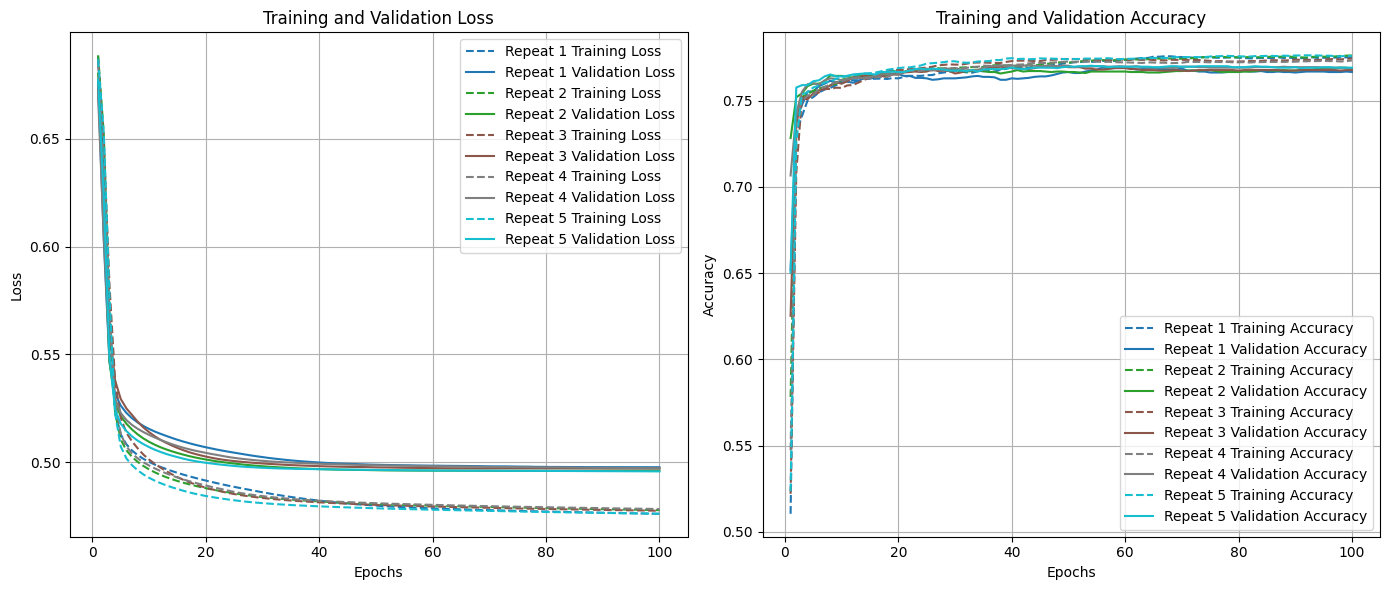

In [8]:
# Create subplots
plot_loss_acc(history)


In [23]:
# Print performance metrics
display(Markdown(f'# CNN Performance Metrics'))
display(present_metrics(all_results))





# CNN Performance Metrics

,Repeat 1,Repeat 2,Repeat 3,Repeat 4,Repeat 5,Average
Precision,0.802118,0.800131,0.800656,0.800000,0.796272,0.799835
Recall,0.696152,0.703619,0.701321,0.705342,0.711660,0.703619
F-score,0.745387,0.748778,0.747704,0.749695,0.751592,0.748631
Accuracy,0.766695,0.768385,0.767822,0.768949,0.769231,0.768216
Miss Rate,0.194414,0.189219,0.190826,0.187981,0.183883,0.189264
Fall out rate,0.165376,0.169248,0.168142,0.169801,0.175332,0.169580


In [22]:
# Print performance metrics
present_metrics(all_results).to_markdown(index=True)

'|               |   Repeat 1 |   Repeat 2 |   Repeat 3 |   Repeat 4 |   Repeat 5 |   Average |\n|:--------------|-----------:|-----------:|-----------:|-----------:|-----------:|----------:|\n| Precision     |   0.802118 |   0.800131 |   0.800656 |   0.8      |   0.796272 |  0.799835 |\n| Recall        |   0.696152 |   0.703619 |   0.701321 |   0.705342 |   0.71166  |  0.703619 |\n| F-score       |   0.745387 |   0.748778 |   0.747704 |   0.749695 |   0.751592 |  0.748631 |\n| Accuracy      |   0.766695 |   0.768385 |   0.767822 |   0.768949 |   0.769231 |  0.768216 |\n| Miss Rate     |   0.194414 |   0.189219 |   0.190826 |   0.187981 |   0.183883 |  0.189264 |\n| Fall out rate |   0.165376 |   0.169248 |   0.168142 |   0.169801 |   0.175332 |  0.16958  |'

## Save model

In [10]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save